# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [63]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [64]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [65]:
# Import the necessary CSVs to Pandas DataFrames
path = Path('Data/sfo_neighborhoods_census_data.csv')
sfo_data = pd.read_csv(path, index_col="year")
sfo_data = sfo_data.fillna(0).astype({'sale_price_sqr_foot' : int})
print(sfo_data.head())

coordinate_data = Path('Data/neighborhoods_coordinates.csv')
coordinate_df = pd.read_csv(coordinate_data, index_col='Neighborhood')
print(coordinate_df.head())

          neighborhood  sale_price_sqr_foot  housing_units  gross_rent
year                                                                  
2010      Alamo Square                  291         372560        1239
2010        Anza Vista                  267         372560        1239
2010           Bayview                  170         372560        1239
2010  Buena Vista Park                  347         372560        1239
2010  Central Richmond                  319         372560        1239
                       Lat         Lon
Neighborhood                          
Alamo Square     37.791012 -122.402100
Anza Vista       37.779598 -122.443451
Bayview          37.734670 -122.401060
Bayview Heights  37.728740 -122.410980
Bernal Heights   37.728630 -122.443050


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

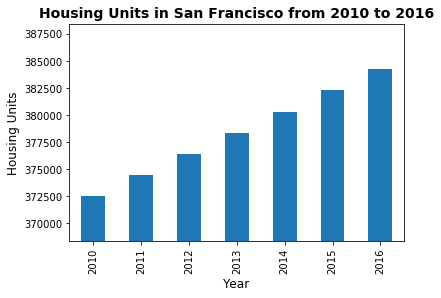

In [66]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    # Calculate the mean number of housing units per year (hint: use groupby) 
    mean_data = sfo_data.groupby('year').mean()
    mean_units = mean_data['housing_units']
    
    mean_housing_units_graph = mean_units.plot.bar(legend=False)
    plt.title('Housing Units in San Francisco from 2010 to 2016',fontsize=14, fontweight='bold')
    plt.xlabel('Year',fontsize=12)
    plt.xticks(rotation=90)
    plt.ylabel('Housing Units',fontsize=12)
    mean_housing_units_graph.set_ylim(
    mean_units.min()-mean_units.std(),
    mean_units.max()+mean_units.std()
    )
    
    return mean_housing_units_graph

housing_units_per_year()


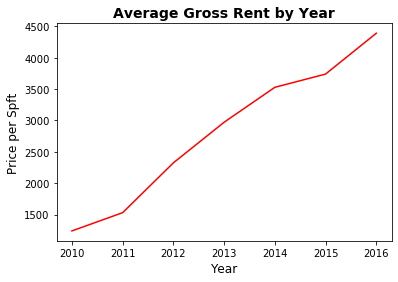

In [67]:
def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    mean_data = sfo_data.groupby('year').mean()
    mean_units = mean_data['housing_units']
    mean_gross_rent = mean_data['gross_rent']
    mean_gross_rent_line = mean_gross_rent.plot(legend=False,color='Red')
    plt.title('Average Gross Rent by Year',fontsize=14, fontweight='bold')
    plt.xlabel('Year',fontsize=12)
    plt.ylabel('Price per Spft',fontsize=12)

    return mean_gross_rent_line

average_gross_rent()

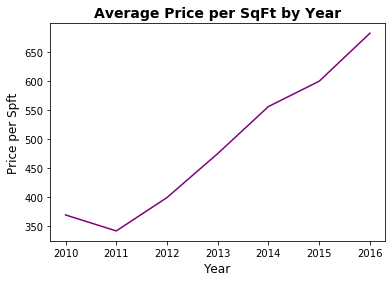

In [68]:

def average_sales_price():
    """Average Sales Price Per Year."""
    mean_data = sfo_data.groupby('year').mean()
    mean_units = mean_data['housing_units']
    mean_price_sq_ft = mean_data['sale_price_sqr_foot']
    mean_gross_rent = mean_data['gross_rent']
    mean_price_sq_ft_line = mean_price_sq_ft.plot(legend=False, color='Purple')
    plt.title('Average Price per SqFt by Year',fontsize=14, fontweight='bold')
    plt.xlabel('Year',fontsize=12)
    plt.ylabel('Price per Spft',fontsize=12)

    return mean_price_sq_ft_line

average_sales_price()

In [69]:

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    annual_avg = sfo_data.groupby(['year','neighborhood']).apply(lambda x: x)
    plot_price_avg = annual_avg.hvplot(
    x='year',
    xlabel='Year',
    y='sale_price_sqr_foot',
    ylabel='Avg. Sale Price per Square Foot',
    groupby=['neighborhood'],
    )
    return plot_price_avg

average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [70]:

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    annual_avg = sfo_data.groupby(['year','neighborhood']).apply(lambda x: x)
    neighborhood_group = annual_avg.groupby(['neighborhood']).mean()
    neighborhood_group = neighborhood_group.sort_values(by=['sale_price_sqr_foot'],ascending=False).reset_index()
    top_10_neighborhood = neighborhood_group.head(10)
    plot_top_10_price = top_10_neighborhood.hvplot.bar(
    x='neighborhood',
    y='sale_price_sqr_foot',
    xlabel='Neighborhood',
    ylabel='Avg. Sale Price per Square Foot',
    rot=90,
    width=800,
    height=400)
    return plot_top_10_price

top_most_expensive_neighborhoods()


:Bars   [neighborhood]   (sale_price_sqr_foot)

In [71]:


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    annual_avg = sfo_data.groupby(['year','neighborhood']).apply(lambda x: x)
    neighborhood_group = annual_avg.groupby(['neighborhood']).mean()
    neighborhood_group = neighborhood_group.sort_values(by=['sale_price_sqr_foot'],ascending=False).reset_index()
    plot_top_10_rent = annual_avg.hvplot.bar(
    x='year',
    xlabel='Neighborhood',
    y=['gross_rent','sale_price_sqr_foot'],
    ylabel='Num Housing Units',
    groupby='neighborhood',
    rot=90,
    figsize=(1000,60))
    return plot_top_10_rent

most_expensive_neighborhoods_rent_sales()


:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [72]:
def neighborhood_map():
    """Neighborhood Map."""
    annual_avg = sfo_data.groupby(['year','neighborhood']).apply(lambda x: x)
    neighborhood_avg = annual_avg.reset_index().groupby('neighborhood')[['sale_price_sqr_foot','housing_units','gross_rent']].mean().astype(int)
    neighborhood_avg_coord = pd.concat([coordinate_df,neighborhood_avg],axis=1,join='inner')
    neighborhood_avg_coord = neighborhood_avg_coord.reset_index().rename(columns={'index':'neighborhood'})
    load_dotenv('token.env')
    map_box_api = os.getenv('mapbox')
    px.set_mapbox_access_token(map_box_api)
    neighborhood_map = px.scatter_mapbox(
        neighborhood_avg_coord,
        lat='Lat',
        lon='Lon',
        color='gross_rent',
        size='sale_price_sqr_foot',
        color_continuous_scale=px.colors.cyclical.IceFire
        )

    return neighborhood_map

neighborhood_map()
    




## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [73]:
# Create a Title for the Dashboard
dash_title = pn.Column("# Real Estate Analysis of San Francisco from 2010 to 2016",row)

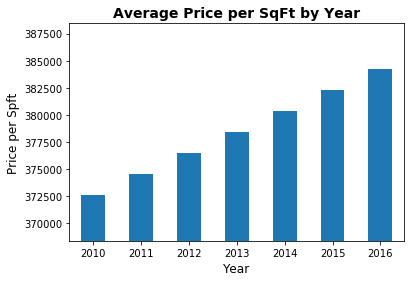

In [74]:
# Create a tab layout for the dashboard
tab_2 = pn.Column(housing_units_per_year(), average_gross_rent(), average_sales_price())
tab_3 = pn.Column(top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())



# Create the dashboard
real_estate_dashboard = pn.Tabs(
    ('Welcome', dash_title),
    ('Yearly Market Analysis', tab_2),
    ('Neighborhood Analysis',tab_3)
)


## Serve the Panel Dashboard

In [75]:
# Serve the# dashboard
real_estate_dashboard.servable()
real_estate_dashboard.show()

Launching server at http://localhost:58512


# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

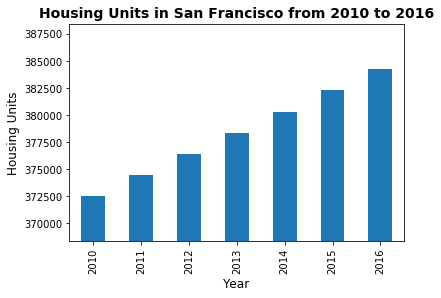

In [76]:
housing_units_per_year()

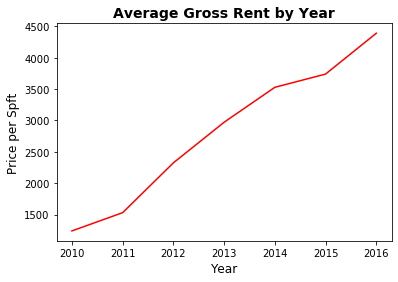

In [77]:
average_gross_rent()

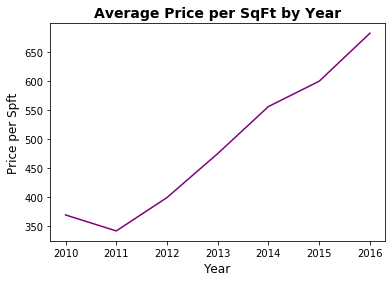

In [78]:
average_sales_price()

In [79]:
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [80]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [81]:
most_expensive_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [82]:
neighborhood_map().show()